<h1> Pnuemonia Detection using ResNeT Architecture

In [2]:
# Import Libraries

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
import numpy as np
import os
import pandas as pd

from glob import glob
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# Making layers not trainable
for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5

In [ ]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint, EarlyStopping
#filepath='saved_models/models.h5'
#filepath="saved_models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5" #File name includes epoch and validation accuracy.
filepath="/content/drive/MyDrive/Deep Learning/Pnuemonia Detection Project/Best_model_resnet.hdf5" #File name includes epoch and validation accuracy.

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

callbacks_list = [checkpoint]

In [19]:
# Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

# Generating train and test Dataset
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# File path
path1 = '/content/drive/MyDrive/CNN/Data/train'
path2 = '/content/drive/MyDrive/CNN/Data/test'

# Procesing images before training 
training_set = train_datagen.flow_from_directory(path1,
                                                 target_size = (256, 256),
                                                 batch_size =32 ,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(path2,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Model Fit
history = model.fit_generator(training_set,
                         steps_per_epoch = 163,
                         epochs = 20,
                         validation_data = test_set,    
                         validation_steps = 19)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 180s 1s/step - loss: 0.1002 - accuracy: 0.9672 - val_loss: 0.2571 - val_accuracy: 0.9293
Epoch 2/20
163/163 [==============================] - 179s 1s/step - loss: 0.0570 - accuracy: 0.9787 - val_loss: 0.3547 - val_accuracy: 0.9128
Epoch 3/20
163/163 [==============================] - 178s 1s/step - loss: 0.0530 - accuracy: 0.9804 - val_loss: 0.3375 - val_accuracy: 0.9079
Epoch 4/20
163/163 [==============================] - 177s 1s/step - loss: 0.0507 - accuracy: 0.9816 - val_loss: 0.2474 - val_accuracy: 0.9243
Epoch 5/20
163/163 [==============================] - 177s 1s/step - loss: 0.0530 - accuracy: 0.9831 - val_loss: 0.2796 - val_accuracy: 0.9112
Epoch 6/20
163/163 [==============================] - 179s 1s/step - loss: 0.0504 - accuracy: 0.9833 - val_loss: 0.2907 - val_accuracy: 0.9112
Epoch 7/20
163/163 [==============================] - 178s 1s/step - loss: 0.0394 - accuracy: 0.9854 - val_loss: 0.3558 - val_accuracy: 0.9030

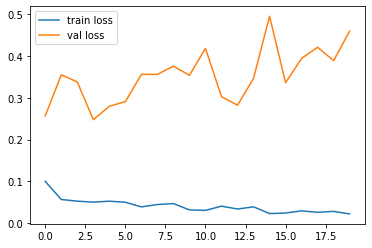

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CNN/LossVal_loss_resnet_20_eps_3')

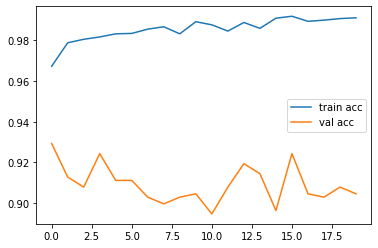

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/CNN/AccVal_acc_renset_20_eps_3')

In [ ]:
model.save('/content/drive/MyDrive/CNN/resnet_model_20_epochs_3.h5')

In [4]:
# Creating a label file of test data

import cv2
def picture_separation(folder):
  '''divide the mixed pictures into NORMAL and PNEUMONIA & add labels to these'''
  X = []
  y = []
  image_list = []

  for foldername in os.listdir(folder):
    if not foldername.startswith('.'):
      if foldername == "NORMAL":
        label = 0
      elif foldername == "PNEUMONIA":
        label = 1
      else:
        label = 2
      
      for image_filename in os.listdir(folder + "/"+ foldername):
        img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,1)
        if img_file is not None:
          img = cv2.resize(img_file,(256,256))
          img_arr = img_to_array(img) / 255
          X.append(img_arr)
          y.append(label)
          image_list.append(foldername + '/' + image_filename)
                                        
  X = np.asarray(X)
  y = np.asarray(y)
    
  return X, y, image_list

In [5]:
# get test dataset with labels
X_test, y_test, img_test = picture_separation('/content/drive/MyDrive/CNN/Data/test')

test_df = pd.DataFrame(img_test, columns = ["images"])
test_df["target"] = y_test

#preview
test_df.head()

,images,target
0,PNEUMONIA/person101_bacteria_484.jpeg,1
1,PNEUMONIA/person100_bacteria_475.jpeg,1
2,PNEUMONIA/person100_bacteria_480.jpeg,1
3,PNEUMONIA/person100_bacteria_481.jpeg,1
4,PNEUMONIA/person100_bacteria_477.jpeg,1


In [6]:
# Load Model
model = keras.models.load_model('/content/drive/MyDrive/CNN/resnet_model_20_epochs_3.h5')

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

#make prediction
yhat_test = model.predict_classes(X_test)

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[173  61]
 [  4 386]]


In [8]:
# Visualize Confusion Matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(b = None)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

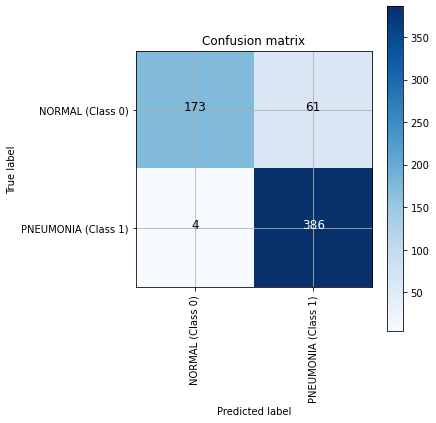

In [9]:
#plot confustion matrix
plot_confusion_matrix(cm, classes = ['NORMAL (Class 0)','PNEUMONIA (Class 1)'], normalize = False)

In [10]:
# Classification report to evaluate other metrics

from sklearn.metrics import classification_report

print('RESNET50 Architecture', '\n', classification_report(y_test, yhat_test, target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

RESNET50 Architecture 
                      precision    recall  f1-score   support

   NORMAL (Class 0)       0.98      0.74      0.84       234
PNEUMONIA (Class 1)       0.86      0.99      0.92       390

           accuracy                           0.90       624
          macro avg       0.92      0.86      0.88       624
       weighted avg       0.91      0.90      0.89       624



AUC: 0.8645299145299146


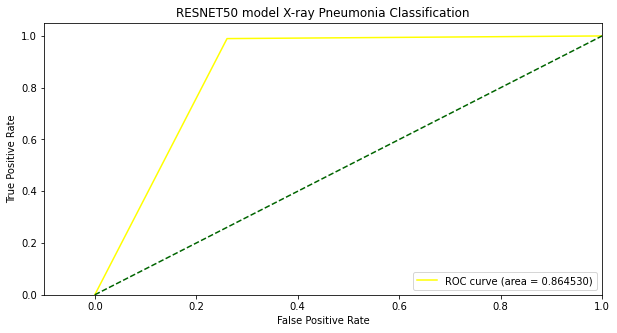

In [11]:
# ROC and AUC curve to evaluate model

from sklearn.metrics import auc,roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, yhat_test)
auc = roc_auc_score(y_test, yhat_test)
print('AUC:', auc)

plt.figure(figsize = (10, 5))
plt.plot(fpr, tpr, color = 'yellow', label = 'ROC curve (area = %f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'darkgreen')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RESNET50 model X-ray Pneumonia Classification')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# Testing image

import numpy as np
from keras.preprocessing import image
path3 = '/content/drive/MyDrive/CNN/Data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
test_image = image.load_img(path3, target_size = (256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'PNEUMONIA'
    print(prediction)
else:
    prediction = 'NORMAL'
    print(prediction)

<h3><b>Model has same performance as basic model. Hence, RESNET could not give better results.